# Spatial entropy of cell locations (cold local minima) in IR
For evolutionary theory paper 

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob 

In [2]:
datadirs = glob('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/*') 
datadirs

['/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels',
 '/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations_5timelevels',
 '/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater',
 '/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_1yearlater']

In [3]:
cases = ['Amaz','SPCZ','Amaz+1y','SPCZ+1y']
nfiles = []
for idir in datadirs: 
    fnames = glob(idir+'/*') 
    print(len(fnames)) 
    nfiles.append(len(fnames))

242
142
235
142


In [4]:
ds = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amz_1yearlater/Amz_23Z_2001-01-04_12hleadup+YEAR.nc' ) #, combine='nested', concat_dim='case') 
ds

<xarray.Dataset>
Dimensions:    (lat: 571, lon: 572, time1: 5)
Coordinates:
  * lat        (lat) float32 -20.93 -20.86 -20.79 -20.72 ... 18.83 18.9 18.97
  * lon        (lon) float32 -74.65 -74.58 -74.51 ... -34.82 -34.75 -34.68
  * time1      (time1) datetime64[ns] 2002-01-04T12:00:00 ... 2002-01-05
    time1_run  (time1) datetime64[ns] ...
Data variables:
    irwin_cdr  (time1, lat, lon) float32 ...

In [5]:
# Amazon and SPCZ UTC values (LST daytime, 15h), for plot labels later 
SUTCs = np.array([21,  0,  3,  6,  9])
AUTCs = (SUTCs + 14) % 24
AUTCs

array([11, 14, 17, 20, 23])

# Definition for cell locations: minima colder than threshold 

In [6]:
from scipy.ndimage import gaussian_filter, minimum_filter

def find_local_minima(data, sigma=1.0, neighborhood_size=3):
    # Find local minima using a minimum filter
    minima = data == minimum_filter(data, footprint=np.ones((neighborhood_size, neighborhood_size)))
    return minima

def smooth_array(data, sigma=1.0):
    smoothed_data = gaussian_filter(data, sigma=sigma)
    return smoothed_data

In [7]:
# Utility for a coastline() function for quick plots 
DEM05 = xr.open_dataset('./DEM.halfdeg.nc')

#lon fixer: #DEM05 = DEM05.roll(lon=(DEM05.sizes['lon'] // 2)) #DEM05['lon'] = (DEM05['lon'] + 180) % 360
def coastline(**kwargs): 
    DEM05.z.plot.contour(vmin=0, vmax=0.01, **kwargs)

# Trehshold -40C (ice), Gaussian smoother sigma=1.0

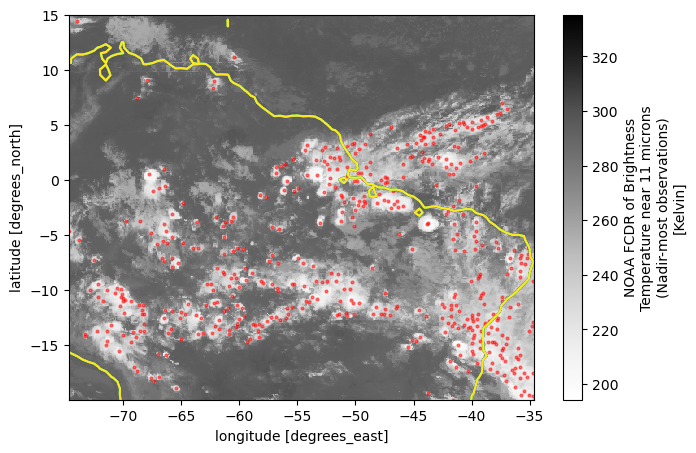

In [8]:
# TEST IMAGE and minima
IRTHRESHOLD = 273-40 

image = ds.irwin_cdr[4]
minima = find_local_minima( smooth_array(image, sigma=1) )
coldminima = minima & (image.values < IRTHRESHOLD)
cells = np.where(coldminima) # tuple of locations, y in [0] and x in [1] oddly

# Slice lat to -20,15
image.sel(lat=slice(-20,15)).plot(cmap='Greys', size=5, aspect=1.5)
plt.scatter( ds.lon[cells[1]] , ds.lat[cells[0]], c='red', alpha=0.5, s=4 );
coastline()

# Composite of probability, by distance from cells

numpy.pad(array, pad_width, mode='constant', **kwargs) 

Text(0.5, 1.0, 'log of probability with distance')

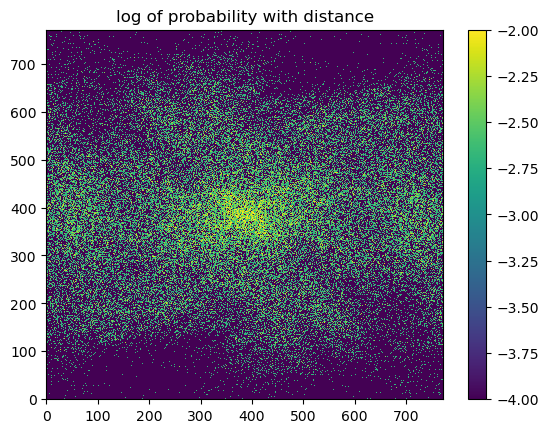

In [9]:
# Loop over locations, roll the array, and tally the sum of a categorical (0 or 1) array

padded = np.pad(coldminima, 100)

composite_sum = padded*0.0
composite_num = 0.0   # no need for array like int(ccold.values *0) unless there are missing data 

# Locations to center the composite around 
i_vals, j_vals = np.where(padded) 
NX,NY = padded.shape
halfNX = int(NX/2); halfNY = int(NY/2)

# Loop over locations, roll the array, and tally the sum 
for active in range( len(i_vals) ):
    rolled = np.roll(padded, (halfNX-i_vals[active], halfNY-j_vals[active]), axis=(0, 1))
    composite_sum += rolled
    composite_num += 1.0 

# Final result:
composite = composite_sum / composite_num

# Plot it: 
plt.pcolormesh( np.log10(composite + 1e-99), vmin=-4, vmax=-2 ); plt.colorbar(); 
plt.title('log of probability with distance') 

# Looping over all cases and times 

In [281]:
# loop over all filenames and sum up the frequency of categorical (0 or 1) arrays

IRTHRESHOLD = 273-40 

results = np.ones( (4,5,5,400,400) ) # central 401x401 box of composite space, for all 5 times of day, with basetimes [0,4], for all 4 cases

for idir,dir in enumerate(datadirs): 
    print('working on cases in ', dir)
    fnames = glob(dir+'/*') 
    for fname in fnames: 
        print(fname) 
        ds = xr.open_dataset(fname) 
        NT,NLAT,NLON = ds.irwin_cdr.shape
        IR512 = ds.irwin_cdr.isel(lat = slice(NLAT//2-256,NLAT//2+256), lon = slice(NLON//2-256,NLON//2+256)) 
# 5,512,512 container for the Boolean cell arrays 
        coldminima = IR512.values*0.0      
        
# get the (coldminima arrays) for each time, from transforming IR512 (a cell finding algorithm) 
        for itime in range(NT):
            image = IR512[itime]
            minima = find_local_minima( smooth_array(image, sigma=1) )
            cell_yesno = minima & (image < IRTHRESHOLD)
            coldminima[itime,:,:] = cell_yesno  
# Padding around horizontal edges, and set up to adjust centerpoint with halfNX and halfNY
        pad_cells = np.pad(coldminima, ((0,0),(200,200),(200,200)) )
        NX,NY = pad_cells[0,:,:].shape
        halfNX = int(NX/2); halfNY = int(NY/2)

        
# Begin composite building 
        for ibase,basetime in enumerate( range(NT) ):    #   [0,4]): when I did only 
# Locations to center the composite around: "cells" in an "image" drawn from unpadded IR512
            i_vals, j_vals = np.where( pad_cells[basetime,:,:] ) # locations of all "cells" aka points in (coldminima ==True)

# Loop over cells, rolling the padded data for all 5 time levels at once 
            for cell in range( len(i_vals) ):                
                rolled = np.roll(pad_cells, (0, halfNX-i_vals[cell], halfNY-j_vals[cell]), axis=(0,1,2) )
# gather up the results in the central 401x401 area, for all 5 times in padded array, for basetime 0 or 4 (indexed as 0,1)
                results[idir, ibase, :,:,:] +=  rolled[:,halfNX-200:halfNX+200, halfNY-200:halfNY+200]
                

working on cases in  /Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2010-01-01_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2006-09-18_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2007-03-18_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2016-01-19_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2001-01-04_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2019-02-01_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations_5timelevels/AMZ_23Z_2011-05-19_12hleadup.nc
/Us

# Plot results! 

In [299]:
results[:,:,:,200,200] /= 1e4      # just to make it not a spike, without losing the information content

Text(0.5, 1.0, 'cell numbers with distance')

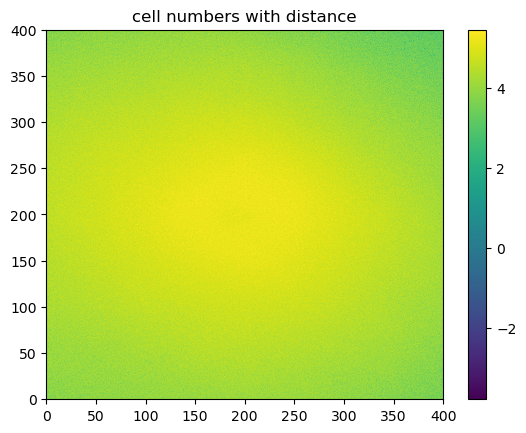

In [300]:
# Plot it: 
plt.pcolormesh( np.log(results[2,1,4,:,:]+1e-99) )   # vmin=-4, vmax=-2 ); 
plt.colorbar(); 
plt.title('cell numbers with distance') 

In [301]:
x = np.linspace(0,400,400)*8
y = np.linspace(0,400,400)*8
LST = np.array( range(5) )
basetime = np.array( range(5) )
exp = np.array( range(4) )
print(exp)

[0 1 2 3]


In [314]:
# make xarray array and thenn dataset 
pcell = xr.DataArray(results, \
        coords={'exp':exp, 'basetime':basetime,'time':LST, 'x': x,'y': y}, 
        dims=["exp","basetime","time","x", "y"] )
#        attrs={"units": ['','','hours','km','km'] } )  ### DOESNT WORK

pcellds = pcell.to_dataset( name="pcell" )
#pcellds.x.assign_attrs(units="km")
#pcellds.y.assign_attrs(units="km")
#pcellds.to_netcdf('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/COLDCELLS_CONDPROBA_COMPOSITE.nc') 

# JUMP IN HERE FROM DISK FILE
pcellds = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/COLDCELLS_CONDPROB_COMPOSITE.nc')
pcellds

<xarray.Dataset>
Dimensions:   (exp: 4, basetime: 5, time: 5, x: 400, y: 400)
Coordinates:
  * exp       (exp) int64 0 1 2 3
  * basetime  (basetime) int64 0 1 2 3 4
  * time      (time) int64 0 1 2 3 4
  * x         (x) float64 0.0 8.02 16.04 24.06 ... 3.184e+03 3.192e+03 3.2e+03
  * y         (y) float64 0.0 8.02 16.04 24.06 ... 3.184e+03 3.192e+03 3.2e+03
Data variables:
    pcell     (exp, basetime, time, x, y) float64 ...

In [315]:
# divide by the horizontal area mean of pcell for each UTC, each regime exp, each basetime

pcellds['prob_ratio'] = pcellds.pcell / pcellds.pcell.mean(dim=['x','y'])
pcellds

<xarray.Dataset>
Dimensions:     (exp: 4, basetime: 5, time: 5, x: 400, y: 400)
Coordinates:
  * exp         (exp) int64 0 1 2 3
  * basetime    (basetime) int64 0 1 2 3 4
  * time        (time) int64 0 1 2 3 4
  * x           (x) float64 0.0 8.02 16.04 24.06 ... 3.184e+03 3.192e+03 3.2e+03
  * y           (y) float64 0.0 8.02 16.04 24.06 ... 3.184e+03 3.192e+03 3.2e+03
Data variables:
    pcell       (exp, basetime, time, x, y) float64 15.0 15.0 9.0 ... 2.0 5.0
    prob_ratio  (exp, basetime, time, x, y) float64 0.3599 0.3599 ... 0.2017

In [316]:
# add distance-from-center array to pcellds 
xx, yy = np.meshgrid(x, y)
distance = np.sqrt( (xx-xx.mean())**2 + (yy-yy.mean())**2 )
distancex = xr.DataArray(distance, coords={'x': x,'y': y}, dims=["x", "y"] )
pcellds['distance'] = distancex
# pcellds.to_netcdf('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/COLDCELLS_CONDPROB_COMPOSITE.nc') # DONE March 9, 2024

In [327]:
# Group by distance in bins from 16 on outward

r_bins = np.array( range(50) )*16 + 32
r_bin_labels = r_bins[1:]-4
pcell_byr = pcellds.groupby_bins("distance", r_bins, labels=r_bin_labels).mean()

# divide by the basetime and time mean of pcell(r,t)
pcell_byr['pr_over_tmean'] = pcell_byr.pcell / pcell_byr.pcell.mean(dim=['basetime'])
pcell_byr

<xarray.Dataset>
Dimensions:        (exp: 4, basetime: 5, time: 5, distance_bins: 49)
Coordinates:
  * exp            (exp) int64 0 1 2 3
  * basetime       (basetime) int64 0 1 2 3 4
  * time           (time) int64 0 1 2 3 4
  * distance_bins  (distance_bins) int64 44 60 76 92 108 ... 748 764 780 796 812
Data variables:
    pcell          (distance_bins, exp, basetime, time) float64 329.1 ... 32.6
    prob_ratio     (distance_bins, exp, basetime, time) float64 7.897 ... 1.315
    distance       (distance_bins) float64 40.76 56.98 73.15 ... 792.3 808.1
    pr_over_tmean  (distance_bins, exp, basetime, time) float64 1.399 ... 0.827

Text(0.5, 1.0, 'SPCZ pcell, base=evening')

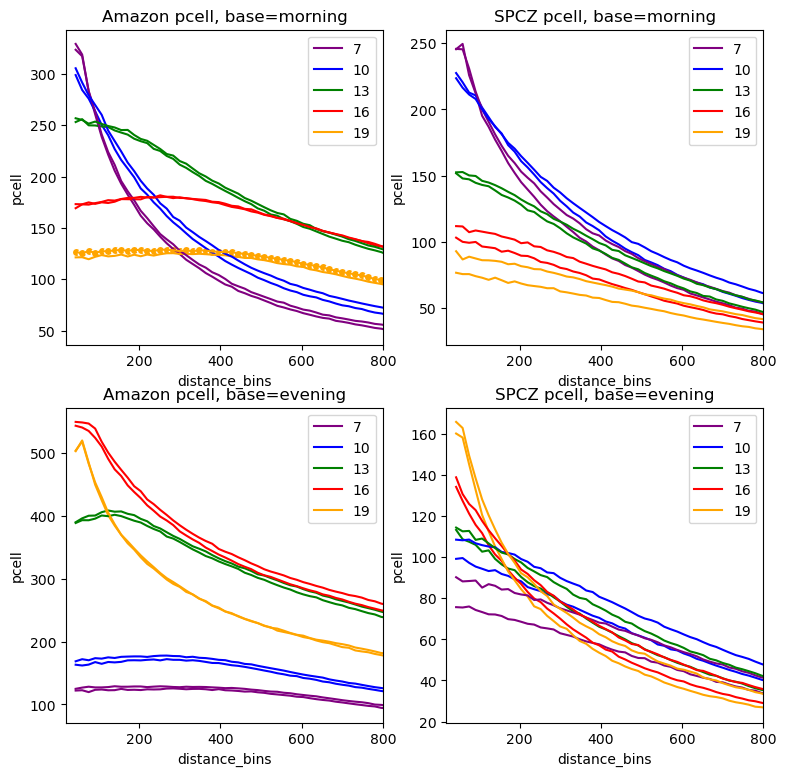

In [328]:
# basetime 0 for Amazon for both MCS and +1year samples
plt.figure( figsize = (9,9) ) 

var = 'pcell' # raw numbers 
# var = 'prob_ratio' #divided by the horizontal mean at each time of day for each exp and basetime, emphasizes r<500km 
# var = 'pr_over_tmean' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle

tcolors = ['purple','blue','green','red','orange']  # predawn to evening
# Basetime 0: 

# Amaxon, MCS and +1y
plt.subplot(221)
for it in range(5): 
    pcell_byr[var][:,0,0,it].plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    pcell_byr[var] [:,2,0,it].plot(c=tcolors[it]) #, label=AUTCs[it]) 
# one scatter plot to see the bin centers 
pcell_byr[var] [:,2,0,it].plot.scatter(c=tcolors[it]) #, label=AUTCs[it]) 
plt.xlim( [20,800] )
plt.legend(loc='upper right')
plt.title('Amazon '+var+', base=morning')

# SPCZ, MCS and +1y
plt.subplot(222)
for it in range(5): 
    pcell_byr[var] [:,1,0,it].plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    pcell_byr[var] [:,3,0,it].plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [20,800] )
plt.legend(loc='upper right')
plt.title('SPCZ '+var+', base=morning')


# Basetime 4: 

# Amazon, MCS and +1y
plt.subplot(223)
for it in range(5): 
    pcell_byr[var] [:,0,4,it].plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    pcell_byr[var] [:,2,4,it].plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [20,800] )
plt.legend(loc='upper right')
plt.title('Amazon '+var+', base=evening')

# SPCZ, MCS and +1y
plt.subplot(224)
for it in range(5): 
    pcell_byr[var] [:,1,4,it].plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    pcell_byr[var] [:,3,4,it].plot(c=tcolors[it]) #, label=AUTCs[it])
plt.xlim( [20,800] )
plt.legend(loc='upper right')
plt.title('SPCZ '+var+', base=evening')

Text(0.5, 1.0, 'SPCZ: conditional prob at each basetime')

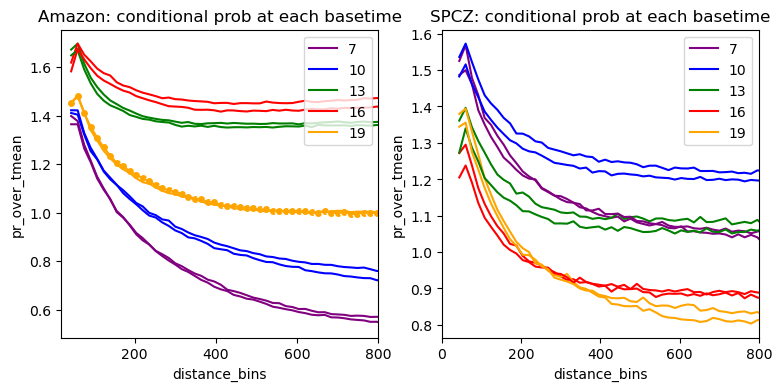

In [336]:
# Another plot: the cond prob at each time of day 
var = 'pcell' # raw numbers 
var = 'prob_ratio' #divided by the horizontal mean at each time of day for each exp and basetime, emphasizes r<500km 
var = 'pr_over_tmean' #divided by a time mean composite radial profile for each exp and basetime, emphasizes diurnal cycle

plt.figure( figsize = (9,4) ) 

# Amazon, MCS and +1y
plt.subplot(121)

for it in range(5): 
    pcell_byr[var][:,0,it,it].plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    pcell_byr[var] [:,2,it,it].plot(c=tcolors[it]) 
# one scatter plot to see the bin centers 
pcell_byr[var] [:,2,it,it].plot.scatter(c=tcolors[it]) 
plt.xlim( [20,800] )

plt.legend(loc='upper right')
plt.title('Amazon: conditional prob at each basetime' )

# SPCZ, MCS and +1y
plt.subplot(122)

for it in range(5): 
    pcell_byr[var][:,1,it,it].plot(c=tcolors[it], label=AUTCs[it]-4)
for it in range(5): 
    pcell_byr[var] [:,3,it,it].plot(c=tcolors[it]) 
plt.xlim( [0,800] )
plt.legend(loc='upper right')
plt.title('SPCZ: conditional prob at each basetime' )

# Assess non-uniformity as entropy difference from max

But over what domain is the probability distributed, to measure what we want to measure? 

In [ ]:
# in comes an array (treated as a histogram, p=hist/sum(hist)), out comes an entropy 
def entropy(histogram): 
    histo = histogram + 1E-99 #.fillna(1E-99) + 1E-99 # replace both 0 and nan with 1 or 2 e-99
    p = histo/np.sum(histo)   # make it into a probability that sums to 1 
    S = -np.sum( p* np.log2(p) ) 
    return S

In [ ]:
def information(histogram): 
    # just make sure it is a PDF (sums to one) 
    PDF = histogram/np.sum(histogram)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99 
    H = -np.log2(nullPDF) - (-np.sum( PDF * np.log2(PDF+1e-99)))
    Smax = -np.log2(nullPDF)
    
    return H, Smax

In [ ]:
# tests of entropy and information functions 